## Precision, Recall, F-measure, Support

- **Precision** = tp / (tp + fp)

- **Recall** = tp / (tp + fn)

- **F1** = 2 * (precision * recall) / (precision + recall)

- **Support** = Number of cases on each class


Precision, Recall and therefore F-measure depend on the probability threshold utilised to determine the class output.

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
)

from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
)

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# load data
data = pd.read_csv('../kdd2004.csv')

# remap target class to 0 and 1
data['target'] = data['target'].map({-1:0, 1:1})

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [3]:
# data size

data.shape

(145751, 75)

In [4]:
# imbalanced target

data.target.value_counts() / len(data)

0    0.991108
1    0.008892
Name: target, dtype: float64

In [5]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

## Baseline: predict the majority class

In [6]:
# Baseline prediction: predict the majority class

y_train_base = pd.Series(np.zeros(len(y_train)))
y_test_base = pd.Series(np.zeros(len(y_test)))

## Train ML models

### Random Forests

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2, n_jobs=4)

rf.fit(X_train, y_train)

y_train_rf = rf.predict_proba(X_train)[:,1]
y_test_rf = rf.predict_proba(X_test)[:,1]

### Logistic Regression

In [8]:
logit = LogisticRegression(random_state=0,  max_iter=1000)

logit.fit(X_train, y_train)

y_train_logit = logit.predict_proba(X_train)[:,1]
y_test_logit = logit.predict_proba(X_test)[:,1]

## Precision

In [9]:
print('Precision Baseline test: ', precision_score(y_test, y_test_base))
print('Precision Random Forest test:', precision_score(y_test, rf.predict(X_test)))
print('Precision Logistic Regression test:', precision_score(y_test, logit.predict(X_test)))

Precision Baseline test:  0.0
Precision Random Forest test: 0.9959183673469387
Precision Logistic Regression test: 0.9299363057324841


## Recall

In [10]:
print('Recall Baseline test: ', recall_score(y_test, y_test_base, pos_label=1))
print('Recall Random Forest test:', recall_score(y_test, rf.predict(X_test), pos_label=1))
print('Recall Logistic Regression test:', recall_score(y_test, logit.predict(X_test), pos_label=1))

Recall Baseline test:  0.0
Recall Random Forest test: 0.6024691358024692
Recall Logistic Regression test: 0.7209876543209877


## F-measure or F1 score

In [11]:
print('F-measure Baseline test: ', f1_score(y_test, y_test_base, pos_label=1))
print('F-measure Random Forest test:', f1_score(y_test, rf.predict(X_test), pos_label=1))
print('F-measure Logistic Regression test:', f1_score(y_test, logit.predict(X_test), pos_label=1))

F-measure Baseline test:  0.0
F-measure Random Forest test: 0.7507692307692309
F-measure Logistic Regression test: 0.812239221140473


## All metrics - 1 function

We can obtain all metrics, for the majority and minority class at the same time, with this function:

- [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [12]:
precision, recall, fscore, support = precision_recall_fscore_support(
    y_test, rf.predict(X_test), pos_label=1,
)

print('Random Forests Precision: ', precision)
print('Random Forests Recall: ', recall)
print('Random Forests f-score: ', fscore)
print('Support: ', support)

Random Forests Precision:  [0.99629723 0.99591837]
Random Forests Recall:  [0.99997692 0.60246914]
Random Forests f-score:  [0.99813368 0.75076923]
Support:  [43321   405]


The first element in each list corresponds to the metrics for the majority class, the second element in each list corresponds to the metrics for the minority class (see that they coincide with those values obtained when we calculated the metrics individually).

See also that they match with the values obtained with Yellobrick below:

## Full classification report

https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html

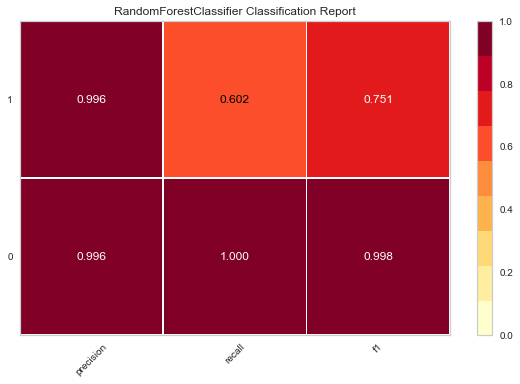

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [13]:
visualizer = ClassificationReport(rf)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

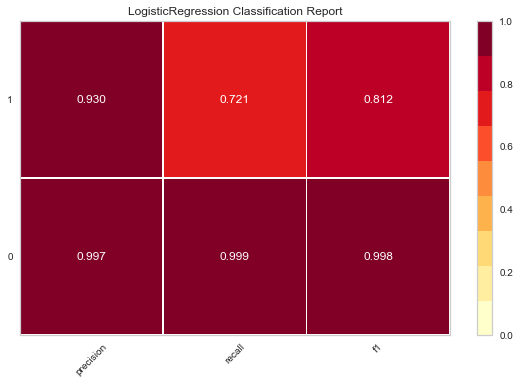

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [14]:
visualizer = ClassificationReport(logit)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

# Precision and Recall, vs probability threshold

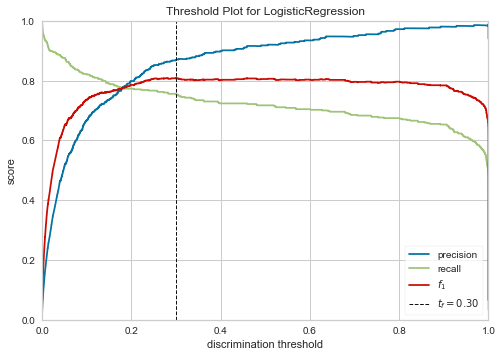

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [15]:
visualizer = DiscriminationThreshold(logit,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()